# JAX for Beginners, Novices and Experts
## Alex Rutherford
## 5th July 2024

# Some caveats

- Not an ML expert  
- This presentation not focused on a paper  
- More focused on Python wrapper to JAX and how to use it. 

![jax paper](figs/jax_paper.png)

[Compiling machine learning programs via high-level tracing](https://mlsys.org/Conferences/doc/2018/146.pdf) (2018) Frostig et al

# JAX at a high level
- JAX is a library for accelerated low level numerical operations
- Built primarily (but not only!) for ML
- Gaining traction in advanced ML and outside

# Jax: Beginners
### JAX as a 'plug and play backend'

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
# jax | tensorflow | torch

In [2]:
import keras

In [3]:
keras.backend.backend()

'jax'

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=x_train.shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(set(y_train)), activation="softmax"),
    ]
)

- Simplest way to think of JAX is low level numerical library
- Focused on ML
- Built around doing a small set of things well and quickly

![jax paper](figs/benchmarks.png)

# Jax: Novices
## JAX as a library for accelerated calculations

- Using JAX 'under the hood' will give good GPU/TPU acceleration
- JAX has it's own powerful API
- Main data structure is `jax.Array`
- Built around 4 main functions (small library!)  
    - `jit()`  
    - `grad()`  
    - `vmap()`  
    - `pmap()`  

# `jax.Array`

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import jax.numpy as jnp
import jax

In [12]:
x = jnp.ones(10)
# Borrows Numpy syntax
x

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [10]:
x.cumsum()

Array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)

In [11]:
x.devices()
# Stored on disk

{CpuDevice(id=0)}

# `jit()`

## _A computer can run code faster when provided with as much information as possible_

(Python is slow because it is interpreted [[Python Performance Matters](https://www.youtube.com/watch?v=vVUnCXKuNOg)])

## `jit()` allows for Python code to be _compiled_ and so sped up

In [13]:
def my_func(x):
    return x**2 + 1
# Define a trivial function

In [14]:
x = jnp.arange(1000)
# Make an array

In [15]:
%timeit _ = my_func(x)
# How long does this take to run

114 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now `jit()` the function

In [16]:
my_func_jitted = jax.jit(my_func)

In [18]:
%timeit _ = my_func_jitted(x)

8.38 µs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# `vmap()`

- Using vectorised functions instead of loops is more efficient
- Vectorisation can be fiddly to implement
- `vmap()` allows for easy vectorisation

## A Simple Example ([source](https://dinocausevic.com/2023/06/13/jax-vmap/))

In [19]:
def custom_dot(x, y):
    return jnp.dot(x, y) ** 2 

In [20]:
x = jnp.array([1,2,3])
y = jnp.array([4,5,6])

In [21]:
custom_dot(x,y)

Array(1024, dtype=int32)

# Now try to 'vectorise' over a batch

In [22]:
x = jnp.asarray([
    [2, 2, 2],
    [3, 3, 3]])

y = jnp.asarray([
    [4, 4, 4],
    [5, 5, 5]]) 

In [23]:
custom_dot(x, y)
# TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (2,).

TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (2,).

## This can be fixed specifying the axis for broadcasting

e.g. x[:,-1], axis = 1

## Use a loop

In [24]:
def custom_dot(x, y):
    return jnp.dot(x, y) ** 2

In [25]:
def naive_custom_dot(x_batched, y_batched):
    return jnp.stack([
        custom_dot(v1, v2)
        for v1, v2 in zip(x_batched, y_batched) 
    ])

In [26]:
naive_custom_dot(x, y)

Array([ 576, 2025], dtype=int32)

## Instead of looping, `vmap()` it

In [27]:
x = jnp.asarray([
    [2, 2, 2],
    [3, 3, 3]])

y = jnp.asarray([
    [4, 4, 4],
    [5, 5, 5]])

In [28]:
batched_custom_dot = jax.vmap(custom_dot)

In [29]:
batched_custom_dot(x,y)

Array([ 576, 2025], dtype=int32)

## Now time it

In [30]:
%timeit _ = naive_custom_dot(x,y)
# Quite slow 

467 µs ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit _ = batched_custom_dot(x,y)
# Even slower! (Due to batching overhead on small arrays)

1.05 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Now `vmap()` and time it (with larger arrays)

In [32]:
x = jnp.arange(0,100)
y = jnp.arange(100,200)
# Make some large data arrays

In [33]:
%timeit _ = naive_custom_dot(x,y)
# Quite slow

18.1 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit _ = batched_custom_dot(x,y)
# Faster than looping with large arrays

1.2 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Bonus : Now `jit()` it _and_ `vmap()` it

In [35]:
jitted_batched_custom_dot = jax.jit(batched_custom_dot)

In [36]:
%timeit _ = jitted_batched_custom_dot(x,y)
# Now faster

9.26 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# `pmap()`

- `pmap()` has similar logic to `vmap()`
- Now a function is broadcast to several devices
- Also does compilation (same as applying `jit()`)

API is likely to change, possibly `pmap()` will be deprecated for `xmap()`

# `grad()`

- Returns a function that calculates the gradient of a function
- Consider $x^{2}$
- We know its derivative to be $2x$

In [39]:
x = jnp.arange(0,10,0.100)

In [40]:
def square_func(x):
    return x*x

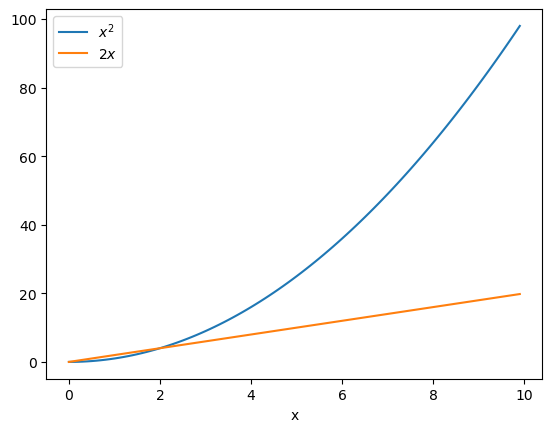

In [41]:
_ = plt.plot(x,square_func(x),label = '$x^{2}$')
_ = plt.plot(x,2*x,label = '$2x$')
_ = plt.legend()
_ = plt.xlabel('x')

In [44]:
square_grad = jax.grad(square_func)

In [45]:
grad_vals = jax.vmap(square_grad)(x)

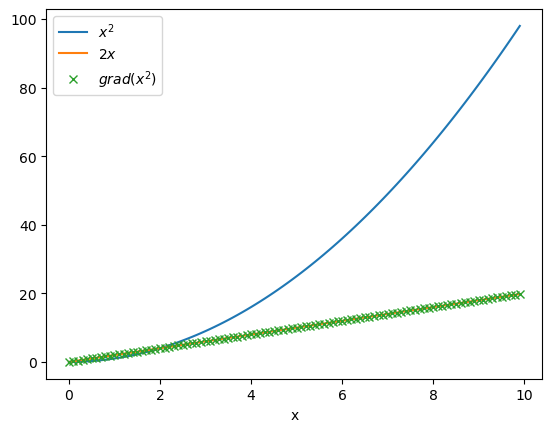

In [46]:
_ = plt.plot(x,square_func(x),label = '$x^{2}$')
_ = plt.plot(x,2*x,label = '$2x$')
_ = plt.plot(x,grad_vals,'x',label = '$grad(x^{2})$')
_ = plt.legend()
_ = plt.xlabel('x')

## This is amazing

In [41]:
%%html
<iframe src="https://giphy.com/embed/26ufdipQqU2lhNA4g" width="480" height="480" style="" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/producthunt-mind-blown-blow-your-26ufdipQqU2lhNA4g">via GIPHY</a></p>

- Instead of 
    - Coding a function 
    - Calculating the derivative by hand 
    - Coding the derivative 
- We can calculate the derivative directly as a new function 

Consider $f(x) = tanh(sin(cos(e^{x})))$

In [47]:
def crazy_func(x):
    return jnp.tanh(jnp.sin(jnp.cos(jnp.exp(x))))

In [16]:
-e^x cos(cos(e^x)) sech^2(sin(cos(e^x))) sin(e^x)
# Wolfram solution

SyntaxError: invalid syntax (4141250471.py, line 1)

In [48]:
x = jnp.arange(0,5,0.100)

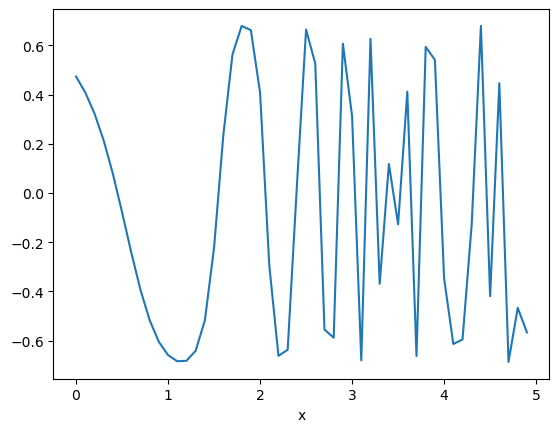

In [49]:
_ = plt.plot(x,crazy_func(x))
_ = plt.xlabel('x')

In [50]:
crazy_func_grad = jax.grad(crazy_func)

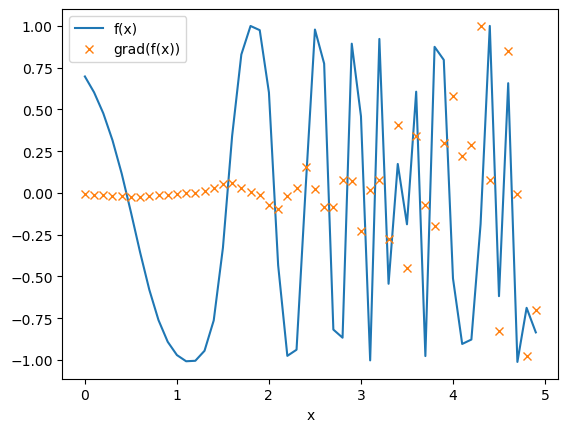

In [51]:
_ = plt.plot(x,crazy_func(x)/jnp.max(crazy_func(x)),label = 'f(x)')
_ = plt.plot(x,jax.vmap(crazy_func_grad)(x)/jnp.max(jax.vmap(crazy_func_grad)(x)),'x',label = 'grad(f(x))')
_ = plt.xlabel('x')
_ = plt.legend()

# Jax: Experts
## JAX as a gradient centric accelerated functional programming language

## Main concepts
1.  Automatic Differentiation
2.  Functional Programming

# 1. Auto Diff 
## (Algorithmic differentiation, AutoGrad)

## There are three methods to calculate a gradient

- Symbolic differentation
- Numerical differentiation
- Algorithmic differentiation

- Algorithmic differentiation underlies back-propagation
- Allows for weights in complex neural networks to be updated
- Represents a whole branch of optimisation (gradient-based optimisation)

![Back prop](https://upload.wikimedia.org/wikipedia/commons/e/ec/Back_Propagation_Example.svg)

[Read more: [alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/](https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/)]

# 2. Functional Programming

- This a distinct style of programming
- Lisp, Perl, Spark are all primarily functional programming languages
- Python, C primarily imperative programming languages

## How do I know if I am doing functional programming?

- Lots of functions!
- No 'side-effects' or 'state'
- Data structures are immutable
- Maps instead of loops

## Comparison to Imperative Programming [[source]](https://en.wikipedia.org/wiki/Functional_programming#Imperative_vs._functional_programming)

In [ ]:
const numList = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10];
let result = 0;
for (let i = 0; i < numList.length; i++) {
  if (numList[i] % 2 === 0) {
    result += numList[i] * 10;
  }
}
# Imperative

In [ ]:
const result = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
               .filter(n => n % 2 === 0)
               .map(a => a * 10)
               .reduce((a, b) => a + b, 0);
# Functional

## These concepts underly JAX

- If functions are 'pure', they can be 'traced'
- Tracing allows JAX to differentiate nested functions of arbitrary complexity
- Including loops, random numbers, control structures (!)

## To be aware of

- These capabilities come with some caveats
- Must be aware of JAX constraints
- Particularly random numbers, JAX friendly versions of functions etc

[[JAX - The sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)]

# Functions with control structures

In [95]:
def naive_cond_func(x):
    
    if x > 1.0:
        return 1.0
    else:
        return 0.0
    # Use standard if/else

In [96]:
naive_cond_func(0.9),naive_cond_func(1.1)
# Fine

(0.0, 1.0)

In [97]:
grad_naive_cond_func = jax.grad(naive_cond_func)
grad_naive_cond_func(1.1)
# Also fine

Array(0., dtype=float32, weak_type=True)

In [98]:
jax.jit(naive_cond_func)(3.)
# Not fine

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function naive_cond_func at /var/folders/k1/53y5f3kj0ds7q7r6fdjsn2kc0000gn/T/ipykernel_74899/917762618.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

## Use JAX friendly operators (`jnp.where()`)

In [84]:
def jax_cond_func(x):
    return jnp.where(x > 1, 1.0, 0.0)
    # Important to use JAX friendly operators like jnp.where
    # Simple if/else will throw an error

In [85]:
jax_cond_func(1.1),jax_cond_func(0.1)

(Array(1., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

In [87]:
grad_jax_cond_func = jax.grad(jax_cond_func)
grad_jax_cond_func(1.0)

In [90]:
jax.jit(jax_cond_func)(0.5)
# Now this is fine

Array(0., dtype=float32, weak_type=True)

# Functions with random numbers

### _In order to be reproducible and vectorisable, random numbers in JAX work differently_

- Necessary to keep track of state of random number generator
- Pass a key to each random number call
- Use each key only once!
- The key can be split to make new keys

In [115]:
from jax import random

key = random.key(42)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 42]


In [58]:
print(random.normal(key))
print(random.normal(key))
# Using the same key twice gives the same result

-0.18471177
-0.18471177


In [116]:
random.normal(key,[10])
# You can use a key to make more than one sample

Array([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,  1.003065  ,
       -0.8708058 , -0.3984997 , -0.6670092 ,  0.33689356,  0.39822492],      dtype=float32)

In [117]:
key, subkey = random.split(key)

In [118]:
random.normal(subkey,[10])

Array([-1.6652092 ,  0.23443979, -0.24498989,  0.44707215,  0.2563031 ,
        0.28259823, -0.11017016,  0.5699527 ,  0.33960482, -1.7104207 ],      dtype=float32)

In [119]:
key, subkey = random.split(key)
# Get another subkey

In [120]:
random.normal(subkey,[10])

Array([ 0.3775522 ,  0.86482465,  0.35859048, -1.3558996 , -1.3783264 ,
       -1.6572771 , -0.9572237 , -0.6402885 ,  1.7951181 ,  2.5553172 ],      dtype=float32)

# Random Number Generation: Example

In [106]:
global global_key 
# Define key as a global variable

In [107]:
global_key = random.key(42)

In [128]:
global_key

Array((), dtype=key<fry>) overlaying:
[2227035060 2872287042]

In [131]:
def rand_func(x):
    
    global global_key
    
    print('\tBefore:',global_key)
    
    global_key, subkey = random.split(global_key)
    # Split global_key, keep one of the new keys
    
    r = jax.random.uniform(shape = [1],key = subkey,minval = 0.0, maxval = 1.0)
    # Use the subkey
    
    print('\tAfter:',global_key)
    
    return jnp.where(r > 0.5, x, 0.0)[0]

In [135]:
for i in range(5):
    print('-> ',rand_func(i))

	Before: Array((), dtype=key<fry>) overlaying:
[3409150811 1941176354]
	After: Array((), dtype=key<fry>) overlaying:
[3771996562  755989044]
->  0.0
	Before: Array((), dtype=key<fry>) overlaying:
[3771996562  755989044]
	After: Array((), dtype=key<fry>) overlaying:
[2247211812  876494065]
->  0.0
	Before: Array((), dtype=key<fry>) overlaying:
[2247211812  876494065]
	After: Array((), dtype=key<fry>) overlaying:
[3390529608 3010500662]
->  0.0
	Before: Array((), dtype=key<fry>) overlaying:
[3390529608 3010500662]
	After: Array((), dtype=key<fry>) overlaying:
[3058230843 2962627691]
->  3.0
	Before: Array((), dtype=key<fry>) overlaying:
[3058230843 2962627691]
	After: Array((), dtype=key<fry>) overlaying:
[4046737378 1557832356]
->  4.0


In [136]:
jax.grad(rand_func)(1.0)
# Now we can take the grad of this random function

	Before: Array((), dtype=key<fry>) overlaying:
[4046737378 1557832356]
	After: Array((), dtype=key<fry>) overlaying:
[590074140 438467548]


Array(0., dtype=float32)

# What can I use JAX for?

- Quick optimisation of existing Python code using `jit()`
- Quickly scaling up ML prototypes
- Directly accessing gradients in complex ML/RL simulations
- Refactoring optimisation problems into gradient-based optimisation framework

# Learn More

## Beginner
- [Video] [Intro to Jax](https://www.youtube.com/watch?v=WdTeDXsOSj4)

## Novice
- [Notebooks] [Jax cookbook](https://www.kaggle.com/code/truthr/learn-jax-from-linear-regression-to-neural-networ?scriptVersionId=91121887)

## Expert
- [Blog] [Intro to Auto Diff](https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/)
- [Video] [DeepMind Session on Jax Ecosystem](https://www.youtube.com/watch?v=iDxJxIyzSiM)
- [Video] [Intro to JaxMD](https://www.youtube.com/watch?v=Bkm8tGET7-w&t=2486s)

# In Summary

![Back prop](figs/8nymkn.jpeg)

In [77]:
jax.make_jaxpr(my_func_jitted)(x)

{ lambda ; a:f32[50]. let
    b:f32[50] = pjit[
      name=my_func
      jaxpr={ lambda ; c:f32[50]. let
          d:f32[50] = integer_pow[y=2] c
          e:f32[50] = add d 1.0
        in (e,) }
    ] a
  in (b,) }

In [73]:
??my_func